In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
# Read and preprocess the dataset

path = '../data/'  # Change this to your path
# return_series = pd.read_parquet(f'{path}usa_returns.parquet')
return_series = pd.read_csv('../data/msci_country_indices.csv', sep= ";", index_col=0 )
return_series.index = pd.to_datetime(return_series.index)
return_series_monthly = np.exp(np.log(1 + return_series).resample('M').sum()) - 1

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(return_series)
return_series_scaled = pd.DataFrame(scaler.transform(return_series),
                                    columns= return_series.columns,
                                    index= return_series.index)
num_stocks= return_series_scaled.shape[1]
print(f"Historical daily returns of {return_series.shape[1]} stocks from {return_series.head(1).index[0]} to {return_series.tail(1).index[0]}")

2024-08-11 14:19:09.164865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-11 14:19:09.227944: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-11 14:19:09.245360: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-11 14:19:09.353630: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-11 14:19:11.002007: W tensorflow/compiler/tf2

Historical daily returns of 24 stocks from 1999-01-01 00:00:00 to 2023-04-18 00:00:00


In [23]:
width = 100 #days
rebdate = return_series.index[width]
X_train = []
y_train = []
train_enddate = return_series.tail(width +1).index[-2]
print(f"train_enddate = {train_enddate}")
step_day = 1

while rebdate < train_enddate:  # num_shape needs to be defined
    X_train_ = return_series[return_series.index < rebdate].tail(width).values.reshape((num_stocks,width))  # train_scaled should be defined
    X_train.append(X_train_)
    y_train.append(return_series[return_series.index >= rebdate].head(1).values[0])
    rebdate += pd.DateOffset(days=step_day)
X_train = np.stack(X_train)
y_train = np.stack(y_train)

train_enddate = 2023-04-17 00:00:00


In [24]:
X_train.shape, y_train.shape

((8732, 24, 100), (8732, 24))

### Dataset description 

For training dataset: 6815 time slices with length of 100 days 

In [68]:
# Initialize the Recurrent Neural Network (RNN) model

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(32, activation= "relu", input_shape=(num_stocks,width),return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(num_stocks))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.RootMeanSquaredError()])

/home/akaboshi/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 32)             │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 24)             │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,816 (69.59 KB)

 Trainable params: 17,816 (69.59 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# Fit the model
history =  model.fit(X_train, y_train, epochs=100, verbose=2)

Epoch 1/100
273/273 - 7s - 26ms/step - loss: 2.0342e-04 - mean_absolute_error: 0.0095 - root_mean_squared_error: 0.0143
Epoch 2/100
273/273 - 1s - 4ms/step - loss: 1.9959e-04 - mean_absolute_error: 0.0094 - root_mean_squared_error: 0.0141
Epoch 3/100
273/273 - 1s - 4ms/step - loss: 1.9786e-04 - mean_absolute_error: 0.0093 - root_mean_squared_error: 0.0141
Epoch 4/100
273/273 - 1s - 4ms/step - loss: 1.9550e-04 - mean_absolute_error: 0.0093 - root_mean_squared_error: 0.0140
Epoch 5/100
273/273 - 1s - 4ms/step - loss: 1.9146e-04 - mean_absolute_error: 0.0093 - root_mean_squared_error: 0.0138
Epoch 6/100
273/273 - 1s - 5ms/step - loss: 1.8837e-04 - mean_absolute_error: 0.0092 - root_mean_squared_error: 0.0137
Epoch 7/100
273/273 - 1s - 4ms/step - loss: 1.8365e-04 - mean_absolute_error: 0.0092 - root_mean_squared_error: 0.0136
Epoch 8/100
273/273 - 1s - 4ms/step - loss: 1.7908e-04 - mean_absolute_error: 0.0091 - root_mean_squared_error: 0.0134
Epoch 9/100
273/273 - 1s - 4ms/step - loss: 1.7

In [70]:
test_size = 50
rebdate = return_series.tail(test_size +1).index[1]
X_test = []
y_test = []
prediction_dates = []
while rebdate < return_series.tail(1).index[-1]:
    X_test_ = return_series[return_series.index < rebdate].tail(width).values.reshape((num_stocks,width))
    X_test.append(X_test_)
    y_test.append(return_series[return_series.index >= rebdate].head(1).values.reshape(num_stocks, step_day))
    rebdate += pd.DateOffset(days=1)
    prediction_dates.append(return_series[return_series.index >= rebdate].index[0])
X_test = np.stack(X_test)
y_test = np.stack(y_test)

In [71]:
predicted_returns = model.predict(X_test).reshape(y_test.shape)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step


<Axes: >

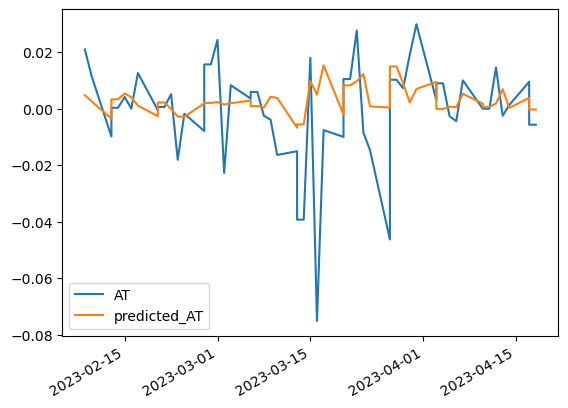

In [72]:
stock_position = 0
test = y_test[:,stock_position].reshape(-1)
prediction = predicted_returns[:,stock_position].reshape(-1)
df = pd.DataFrame({ f"{return_series.columns[stock_position]}": test,
              f"predicted_{return_series.columns[stock_position]}" : prediction},
             index= prediction_dates)
df.plot()

,prediction,benchmark,predicted_relevance,benchmark_relevance
NL,-0.001020,-0.013588,9,1
IT,-0.001480,-0.007067,5,2
AT,-0.000264,-0.005665,16,3
FR,-0.001004,-0.002323,10,4
DE,-0.001426,-0.002086,6,5
CH,-0.000236,-0.001485,17,6
SE,-0.001129,-0.000899,7,7
FI,-0.003270,-0.000671,1,8
ES,-0.001897,-0.000240,3,9
GR,-0.001588,0.000000,4,10


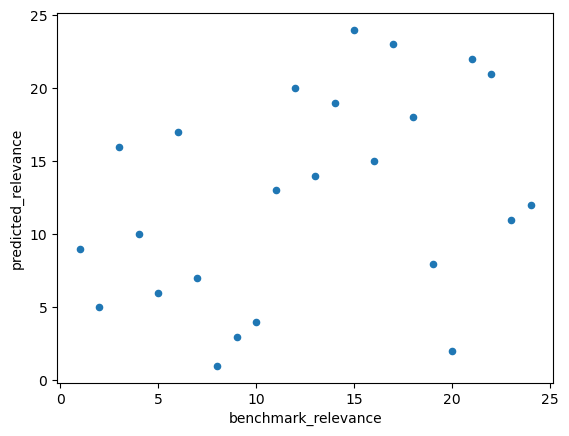

In [73]:
ranking = pd.DataFrame({"prediction": predicted_returns[-1].reshape(-1),
            #   "prediction_rank": predicted_returns[-1].reshape(-1).argsort().argsort(),
             "benchmark": y_test[-1].reshape(-1),
            #  "benchmark_rank": y_test[-1].reshape(-1).argsort().argsort()
            }, index= return_series.columns)
ranking['predicted_relevance'] = ranking["prediction"].rank(ascending=True).astype(int)
ranking['benchmark_relevance'] = ranking["benchmark"].rank(ascending=True).astype(int)

ranking.plot("benchmark_relevance" , "predicted_relevance", kind = "scatter")
ranking.sort_values("benchmark_relevance")

In [53]:
from sklearn.metrics import ndcg_score, average_precision_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

enc = LabelBinarizer()

benchmark = enc.fit_transform(ranking['benchmark_relevance'])
preds = enc.transform(ranking['predicted_relevance'])
print(f"ndcg_score              = {ndcg_score(benchmark, preds,  k=24)}")

ndcg_score              = 0.3008269350704703


## Save model 

In [ ]:
# Save the entire model as a `.keras` zip archive.
# path_model = f"../model/lstm_msci.keras"
# model.save(path_model)
# model_loaded = tf.keras.models.load_model(path_model)
# # Show the model architecture
# model_loaded.summary()

# result = model(X_test[:2])
# result_loaded_model = model_loaded(X_test[:2])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │         1,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,274 (368.26 KB)

 Trainable params: 31,424 (122.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,850 (245.51 KB)

In [ ]:
indx_top = result_loaded_model[-1].numpy().argsort()[:20]
return_series.columns[indx_top]

Index(['GR', 'AT', 'IE', 'ES', 'PT', 'IT', 'SE', 'DE', 'JP', 'BE', 'FI', 'IL',
       'NL', 'US', 'FR', 'CA', 'AU', 'SG', 'CH', 'GB'],
      dtype='object')

In [ ]:
# import tensorflow as tf
# import tf2onnx
# import onnx

# model.output_names=['return_series']
# input_signature = [tf.TensorSpec([None, num_stocks,width], tf.float32)]
# # Use from_function for tf functions
# onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature)
# onnx.save(onnx_model, "../model/model.onnx")


I0000 00:00:1723376098.407898   17673 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723376098.408286   17673 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-08-11 13:34:58.408396: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
I0000 00:00:1723376098.410530   17673 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723376098.411023   17673 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so